In [1]:
#Environment & Dependencies
!pip install -q -U torch torchvision torchaudio transformers efficientnet_pytorch google-generativeai pandas==2.2.2 scikit-learn tqdm

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 40.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 48.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 102.8 MB/s eta 0:00:00


In [2]:
#Imports & Globals
import os, re, json, random, math, base64, warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from efficientnet_pytorch import EfficientNet
from transformers import AutoTokenizer, AutoModel
from scipy.ndimage import center_of_mass
from sklearn.metrics import accuracy_score, classification_report
import google.generativeai as genai

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Running on', device)

Running on cpu


# CSV Loading

In [3]:
#Google Drive Mounting
from google.colab import drive
drive.mount('/content/drive')

DATA_PATH = '/content/drive/Shareddrives/BEST Lab   Squishy Robotics URAP Root/URAP + DevEng/1 - Wildfire/Wildfire - Grace, Stella, Ian/all_db_fire.zip (Unzipped Files)/'
RAW_CSV   = os.path.join(DATA_PATH, 'bdfire/data.csv')

raw = pd.read_csv(RAW_CSV, encoding='ISO-8859-1')
raw.columns = [c.strip().strip('"').strip("'") for c in raw.columns]

Mounted at /content/drive


In [4]:
# French → English column mapping (same order as original)
french_columns = raw.columns.to_list()
english_columns = [
    "ID", "Photo Date", "Media Folder", "Photo", "Infrared", "Ground Truth",
    "Material", "Focal Length", "Sensitivity", "Infrared Spectrum", "Exposure Time",
    "Height", "Width", "Time", "Location", "Region", "GPS Position", "Fire Direction",
    "Occupancy Rate", "Dominant Color", "Density", "Superposition Rate",
    "Smoke Color", "Luminosity", "Vegetation", "Moment", "Cloud",
    "Distance", "Presence", "Valid", "Owner", "Sequence", "Image Number"
]

assert len(french_columns) == len(english_columns), 'Column count mismatch'

data = raw[french_columns].copy()
data.columns = english_columns

In [5]:
# Helper functions for cleaning

def extract_after_slash(text):
    if pd.notnull(text) and '/' in str(text):
        return str(text).split('/')[-1]
    return text if pd.notnull(text) and text != '' else np.nan


def strip_str_field(series: pd.Series):
    return series.apply(lambda x: np.nan if str(x).strip().strip('"').strip("'") == '' else str(x).strip().strip('"').strip("'"))

# apply slash‑extraction to specific categorical columns
for col in ['Fire Direction', 'Dominant Color', 'Smoke Color', 'Vegetation', 'Presence']:
    data[col] = strip_str_field(data[col]).apply(extract_after_slash)

# numeric conversion for quantitative fields
quantitative_fields = [
    "Focal Length", "Sensitivity", "Exposure Time", "Height", "Width",
    "Occupancy Rate", "Density", "Superposition Rate", "Luminosity", "Cloud", "Valid",
    "Sequence", "Image Number"
]
for col in quantitative_fields:
    data[col] = pd.to_numeric(strip_str_field(data[col]), errors='coerce').astype('Int64')

# strip quotes for remaining string fields
for col in ['Photo', 'Infrared', 'Ground Truth', 'Material', 'Time', 'Location', 'Distance']:
    data[col] = strip_str_field(data[col])


In [6]:
# Sequence metadata (seqXXX naming convention)
df_seq = data[data['Photo'].str.contains('seq', na=False)].copy()
df_seq['seq_id'] = df_seq['Photo'].str.extract(r'(seq\d+)')
df_seq = df_seq.sort_values(['seq_id', 'Photo']).reset_index(drop=True)
sequences = df_seq.groupby('seq_id')

In [7]:
# Helper image file lists (RGB / NIR pairs)
rgb_files = sorted([f for f in os.listdir(DATA_PATH) if f.startswith('seq') and 'rgb' in f])
nir_files = sorted([f for f in os.listdir(DATA_PATH) if f.startswith('seq') and 'nir' in f])
paired_frames = [(rgb, nir) for rgb, nir in zip(rgb_files, nir_files) if rgb.split('_')[-1] == nir.split('_')[-1]]

In [8]:
# Descriptor sentence for BERT

def make_descriptor(row):
    parts = [
        f"direction {row['Fire Direction']}",
        f"dominant_color {row['Dominant Color']}",
        f"smoke_color {row['Smoke Color']}",
        f"vegetation {row['Vegetation']}",
        f"presence {row['Presence']}"
    ]
    return ' | '.join([p for p in parts if pd.notnull(p)])

data['descriptor_text'] = data.apply(make_descriptor, axis=1)

# Low‑Level Fire Metrics

In [9]:
# Helper Functions
def compute_area_coverage(mask_path):
    mask = Image.open(mask_path).convert('L')
    arr  = np.array(mask)
    fire = (arr > 128).sum()
    return fire / arr.size


def compute_fire_intensity(rgb_path, gt_path):
    img  = np.array(Image.open(rgb_path).convert('L'))
    mask = np.array(Image.open(gt_path).convert('L')) > 128
    return img[mask].mean() / 255.0


def compute_spread_direction(gt1, gt2):
    m1 = np.array(Image.open(gt1).convert('L')) > 128
    m2 = np.array(Image.open(gt2).convert('L')) > 128
    c1 = np.array(center_of_mass(m1))
    c2 = np.array(center_of_mass(m2))
    return (c2 - c1)  # dy, dx


def compute_superposition(gt_path, rgb_path):
    mask = np.array(Image.open(gt_path).convert('L')) > 128
    img  = np.array(Image.open(rgb_path).convert('L'))
    return img[mask].std() / 255.0

# EfficientNet & BERT Encoders (frozen)

In [10]:
IMG_TF = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print('Loading EfficientNet‑B0…')
EFF_RGB = EfficientNet.from_pretrained('efficientnet-b0').to(device).eval()
EFF_NIR = EfficientNet.from_pretrained('efficientnet-b0').to(device).eval()

print('Loading BERT…')
TOKENIZER = AutoTokenizer.from_pretrained('bert-base-uncased')
BERT      = AutoModel.from_pretrained('bert-base-uncased').to(device).eval()
for p in BERT.parameters():
    p.requires_grad = False

@torch.no_grad()
def img_feat(path, model, grayscale=False):
    img = Image.open(path).convert('RGB')  # replicate channel for NIR
    t   = IMG_TF(img).unsqueeze(0).to(device)
    f   = model.extract_features(t)          # [B,1280,7,7]
    return f.mean([-1, -2]).squeeze(0)       # [1280]

@torch.no_grad()
def desc_feat(text):
    toks = TOKENIZER(text, return_tensors='pt', truncation=True, max_length=32).to(device)
    out  = BERT(**toks)
    return out.last_hidden_state[:,0,:].squeeze(0)  # [768]

Loading EfficientNet‑B0…


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 337MB/s]


Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0
Loading BERT…


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

# Late‑Fusion Transformer Module

In [11]:
class ModalityFusion(nn.Module):
    def __init__(self, d_model=512, nhead=8, nlayers=2):
        super().__init__()
        self.rgb_fc = nn.Linear(1280, d_model)
        self.nir_fc = nn.Linear(1280, d_model)
        self.txt_fc = nn.Linear( 768, d_model)
        enc_layer  = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=nlayers)
        self.pos = nn.Parameter(torch.randn(1,3,d_model))
    def forward(self, rgb, nir, txt):  # each [B,dim]
        tokens = torch.stack([self.rgb_fc(rgb), self.nir_fc(nir), self.txt_fc(txt)], dim=1) + self.pos
        fused  = self.encoder(tokens)  # [B,3,d_model]
        return fused.mean(1)           # [B,d_model]


# Dataset & Dataloader

In [12]:
class FireSeqDataset(Dataset):
    def __init__(self, triples, seq_len=3):
        self.triples  = triples  # list[(rgb_path, nir_path, descriptor_text)]
        self.seq_len  = seq_len
    def __len__(self):
        return len(self.triples) - self.seq_len
    def __getitem__(self, idx):
        rgb_vecs, nir_vecs, txt_vecs = [], [], []
        for j in range(self.seq_len):
            rgb_p, nir_p, txt = self.triples[idx+j]
            rgb_vecs.append(img_feat(rgb_p, EFF_RGB))
            nir_vecs.append(img_feat(nir_p, EFF_NIR, grayscale=True))
            txt_vecs.append(desc_feat(txt))
        rgb_vecs = torch.stack(rgb_vecs)
        nir_vecs = torch.stack(nir_vecs)
        txt_vecs = torch.stack(txt_vecs)

        # Targets (same as original)
        tgt_rgb = self.triples[idx+self.seq_len-1][0]
        tgt_gt  = tgt_rgb.replace('_rgb', '_gt')
        nxt_gt  = self.triples[idx+self.seq_len][0].replace('_rgb', '_gt')

        ac  = compute_area_coverage(tgt_gt)
        it  = compute_fire_intensity(tgt_rgb, tgt_gt)
        sup = compute_superposition(tgt_gt, tgt_rgb)
        dy, dx = compute_spread_direction(tgt_gt, nxt_gt)
        dx, dy = dx/224.0, dy/224.0
        y = torch.tensor([ac, it, sup, dx, dy], dtype=torch.float)
        return rgb_vecs, nir_vecs, txt_vecs, y

# Build triple list with descriptors
triples = []
for rgb, nir in paired_frames:
    desc_row = data.loc[data['Photo'] == rgb]
    desc_txt = desc_row['descriptor_text'].values[0] if len(desc_row) else ''
    triples.append((os.path.join(DATA_PATH,rgb), os.path.join(DATA_PATH,nir), desc_txt))

SEQ_LEN = 3
fire_ds = FireSeqDataset(triples, seq_len=SEQ_LEN)
fire_dl = DataLoader(fire_ds, batch_size=len(fire_ds))  # small dataset → one batch


# End‑to‑End Forecast Model

In [13]:
class LateFusionFireForecast(nn.Module):
    def __init__(self, d_model=512, hidden=128, out_dim=5):
        super().__init__()
        self.fuser = ModalityFusion(d_model=d_model)
        self.lstm  = nn.LSTM(input_size=d_model, hidden_size=hidden, batch_first=True)
        self.head  = nn.Linear(hidden, out_dim)
    def forward(self, rgb, nir, txt):  # each [B,seq_len,dim]
        B,S,_ = rgb.shape
        fused_seq = []
        for t in range(S):
            fused_seq.append(self.fuser(rgb[:,t,:], nir[:,t,:], txt[:,t,:]))
        fused_seq = torch.stack(fused_seq, dim=1)  # [B,S,d_model]
        _, (h, _) = self.lstm(fused_seq)
        return self.head(h[-1])

model = LateFusionFireForecast().to(device)
opt   = torch.optim.Adam(model.parameters(), lr=1e-3)
crit  = nn.MSELoss()

# Training (20 epochs demo)

In [ ]:
print('\nTraining…')
for epoch in range(20):
    for rgb, nir, txt, tgt in fire_dl:
        rgb, nir, txt, tgt = rgb.to(device), nir.to(device), txt.to(device), tgt.to(device)
        opt.zero_grad()
        pred = model(rgb, nir, txt)
        loss = crit(pred, tgt)
        loss.backward()
        opt.step()
    print(f"Epoch {epoch+1:02d} | Loss {loss.item():.4f}")


Training…
Epoch 01 | Loss 0.0698
Epoch 02 | Loss 0.2184
Epoch 03 | Loss 0.0430
Epoch 04 | Loss 0.0182
Epoch 05 | Loss 0.0166
Epoch 06 | Loss 0.0166
Epoch 07 | Loss 0.0132
Epoch 08 | Loss 0.0119
Epoch 09 | Loss 0.0123
Epoch 10 | Loss 0.0127
Epoch 11 | Loss 0.0126
Epoch 12 | Loss 0.0124
Epoch 13 | Loss 0.0120
Epoch 14 | Loss 0.0116
Epoch 15 | Loss 0.0113
Epoch 16 | Loss 0.0112
Epoch 17 | Loss 0.0114
Epoch 18 | Loss 0.0115
Epoch 19 | Loss 0.0116
Epoch 20 | Loss 0.0115


# Evaluation & Plotting

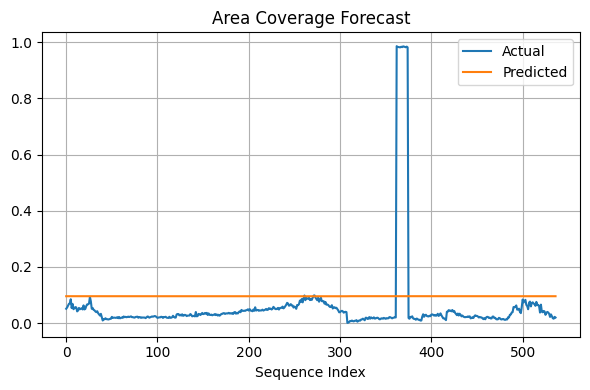

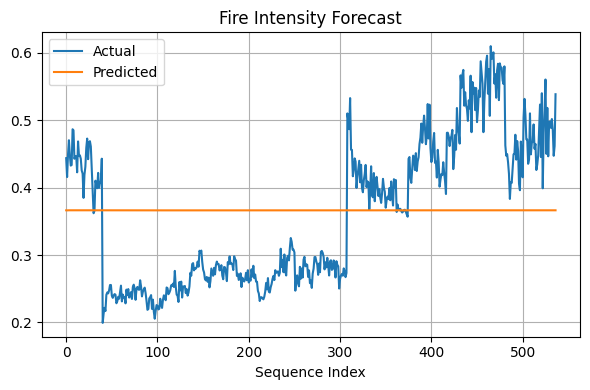

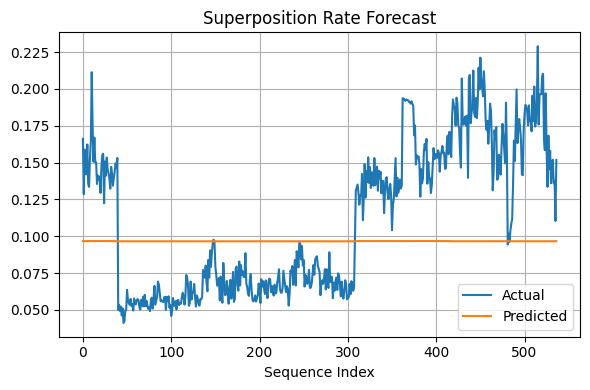

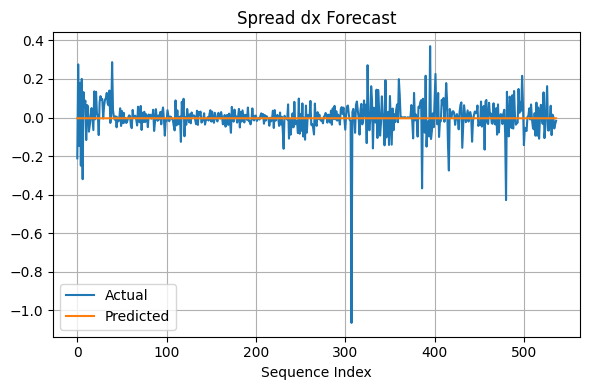

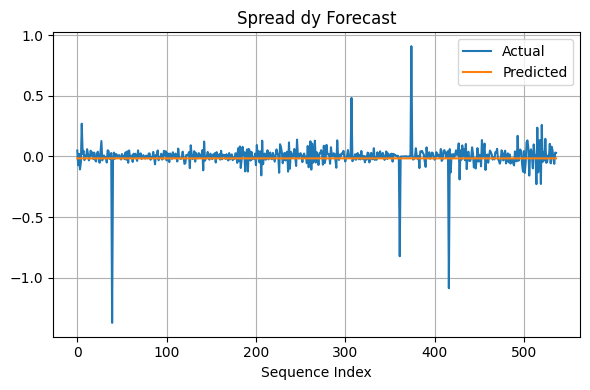

In [ ]:
model.eval()
with torch.no_grad():
    for rgb, nir, txt, tgt in fire_dl:
        rgb, nir, txt = rgb.to(device), nir.to(device), txt.to(device)
        preds = model(rgb, nir, txt).cpu().numpy()
        actual = tgt.numpy()

feat_names = ["Area Coverage","Fire Intensity","Superposition Rate","Spread dx","Spread dy"]
for i, name in enumerate(feat_names):
    plt.figure(figsize=(6,4))
    plt.plot(actual[:,i], label='Actual')
    plt.plot(preds[:,i], label='Predicted')
    plt.title(f"{name} Forecast")
    plt.xlabel('Sequence Index'); plt.grid(); plt.legend(); plt.tight_layout(); plt.show()

# Gemini LLM Descriptor Generation

In [ ]:
key = ''  # ← insert your Gemini API key here
if key:
    genai.configure(api_key=key)

    gemini_model = genai.GenerativeModel('gemini-1.5-flash')
    model.eval(); results = []

    with torch.no_grad():
        for idx, (rgb, nir, txt, _) in enumerate(fire_dl):
            rgb, nir, txt = rgb.to(device), nir.to(device), txt.to(device)
            pred = model(rgb, nir, txt).cpu().numpy()[0]
            area, inten, sup, dx, dy = pred

            prompt = f"""
            The LSTM model predicts:
            Area coverage: {area*100:.1f}%
            Fire intensity: {inten:.2f}
            Superposition rate: {sup*100:.1f}%
            Spread direction vector: dx={dx:.2f}, dy={dy:.2f}

            Please provide the following fire descriptors:
            fire_presence=yes/no
            fire_color=COLOR
            smoke_color=COLOR
            fire_intensity=XXX
            superposition_rate=XX%
            luminosity=XXX
            area_coverage=XX%
            spread_direction=north/east/south/west/northeast/etc
            """
            response = gemini_model.generate_content(prompt)
            def extract(pat, txt, fb=None):
                m = re.search(pat, txt, re.I)
                return m.group(1).strip() if m else fb
            parsed = {
                'fire_presence': extract(r'fire_presence=(\w+)', response.text),
                'fire_color':    extract(r'fire_color=([^\s]+)', response.text),
                'smoke_color':   extract(r'smoke_color=([^\s]+)', response.text),
                'fire_intensity':extract(r'fire_intensity=([^\s]+)', response.text),
                'superposition_rate': extract(r'superposition_rate=(\d+)%', response.text),
                'luminosity':    extract(r'luminosity=([^\s]+)', response.text),
                'area_coverage': extract(r'area_coverage=(\d+)%', response.text),
                'spread_direction': extract(r'spread_direction=([^\s]+)', response.text),
                'seq_idx': idx,
                'raw': response.text
            }
            results.append(parsed)

    results_df = pd.DataFrame(results)
    display(results_df.head())

# Gemini Vision (Flames2 section)

In [ ]:
if key:
    genai.configure(api_key=key)
    vis_model = genai.GenerativeModel('gemini-2.0-flash')

    RGB_SAMPLE_PATH = '/content/drive/My Drive/Third/SP2025/URAP/data/images/rgb_images'
    rgb_files = sorted(os.listdir(RGB_SAMPLE_PATH))[::5]  # every 5th image

    vis_prompt = """
    Analyze the provided image and clearly state:
    - If fire is present or not.
    - Fire location described as clearly as possible (e.g., top-left, bottom-right, center, entire image, multiple locations).
    - If fire is present, describe the fire color, smoke color, estimated intensity (low/medium/high), and approximate area coverage (percentage of image area).

    Respond strictly in the format:
    fire_present=yes/no location=XXX fire_color=XXX smoke_color=XXX intensity=XXX area_coverage=XX%
    """

    preds = []
    for img_file in rgb_files:
        img_path = os.path.join(RGB_SAMPLE_PATH, img_file)
        img_upload = genai.upload_file(path=img_path)
        resp = vis_model.generate_content([vis_prompt, img_upload], generation_config=genai.types.GenerationConfig(temperature=0.2))
        txt = resp.text
        def grab(pat, default=None):
            m = re.search(pat, txt, re.I)
            return m.group(1).strip().lower() if m else default
        preds.append({
            'image': img_file,
            'fire_present': grab(r'fire_present=(yes|no)'),
            'location': grab(r'location=([^\s]+)', 'entire image'),
            'fire_color': grab(r'fire_color=([^\s]+)'),
            'smoke_color': grab(r'smoke_color=([^\s]+)'),
            'intensity': grab(r'intensity=([^\s]+)'),
            'area_coverage_%': int(grab(r'area_coverage=(\d+)%', 0)),
            'raw': txt
        })

    flames2_df = pd.DataFrame(preds)
    display(flames2_df.head())
